<h2>Modelling mass concentration (mg/m³) of chlorophyll a in sea water using data from the CMEMS Data Store</h2>

<hr>
<h4><strong>Data Used</strong></h4>
<ul>
    <li>Copernicus Marine Data</li><br>

| Dataset | CMEMS product ID| CMEMS product<br>description | Variable | Product User Manual |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Baltic Sea Multiyear Ocean Colour Plankton,<br>Reflectances and Transparency L3 daily observations | OCEANCOLOUR_BAL_BGC_L3_MY_009_133 | <a href="https://data.marine.copernicus.eu/product/OCEANCOLOUR_BAL_BGC_L3_MY_009_133/description" target="_blank">Description</a> | Chlorophyll a concentration (CHL-a) mg/m³ | <a href="https://documentation.marine.copernicus.eu/PUM/CMEMS-OC-PUM.pdf" target="_blank">User Manual</a> |
  </ul>
 <ul>   
   <li>Coastal water areas (KVF)

| Dataset | XXX?? resource ID??| Metadata |
|:--------------------:|:-----------------------:|:-------------:|
| VM Vattenförekomster kustvatten 2016-2021 |???|<a href="https://ext-geodatakatalog.lansstyrelsen.se/GeodataKatalogen/srv/api/records/GetMetaDataById?id=ec8c278f-37a5-4fb3-971f-2920ab22609f" target="_blank">Link</a>|
</ul>

<hr>
<h4><strong>Learning Outcomes</strong></h4>

At the end of this notebook you will be able to:
* 
* 
* 

<hr>
<h4><strong>Outline</strong></h4>



<hr>
<h4><strong>References</strong></h4>
<ul>
<li>Brando, V.E.; Sammartino, M; Colella, S.; Bracaglia, M.; Di Cicco, A; D’Alimonte, D.; Kajiyama, T., Kaitala, S., Attila, J., 2021b (accepted). Phytoplankton Bloom Dynamics in the Baltic Sea Using a Consistently Reprocessed Time Series of Multi-Sensor Reflectance and Novel Chlorophyll-a Retrievals. Remote Sens. 2021, 13, x.</li>
<li>D. D’Alimonte, G. Zibordi, and F. Mélin. Statistical Method for Generating CrossMission Consistent Normalized Water-Leaving Radiances. IEEE Trans. Geosc. Rem. Sens., 46 (12): 4075–4093, December 2008. doi: 10.1109/TGRS.2008.2001819
</li>
<li>D. D’Alimonte, G. Zibordi, J.-F. Berthon, E. Canuti, and T. Kajiyama. Bio-optical Algorithms for European Seas: Performance and Applicability of Neural-Net Inversion 
Schemes. Technical Report JRC66326, JRC-IES Scientific and Technical Reports, 2011. URL http://publications.jrc.ec.europa.eu/repository/handle/111111111/22406</li>
<li>D. D’Alimonte, G. Zibordi, T. Kajiyama, and J.-F. Berthon. Comparison between MERIS and regional high-level products in European seas. Remote Sensing of Environment, 
140: 378–395, 2014. ISSN 0034-4257. doi: 10.1016/j.rse.2013.07.029
</ul>

<hr>

<h4><strong>Contents</strong></h4>

<ol>   
<li>Mass concentration of chlorophyll a in sea water (Chl-a) mg/m³</li>
<li></li>
<li></li>
<li></li>
<li></li>
</ol>
<hr>

<div class="alert alert-block alert-warning"> 
<h4>Prerequisites:</h4>
<ol>
   <li><strong><em>Wekeo account: </em></strong> Create an account via "Register" here: <em>https://wekeo.copernicus.eu/</em></li>
   <li><strong><em>Copernicus Marine account: </em></strong> Create an account here: <em>https://data.marine.copernicus.eu/register</em></li>
   <li><strong><em>Two external libraries </em></strong> must be installed in the wekeolab python environment.</li>
   <ul>
      <li>open a terminal in the wekeolab JupyterHub environment</li>
      <li>activate the wekeolab environment <code style="background:red;color:white">conda activate wekeolab</code></li>
      <li>execute the following commands to install the required packages in the wekeolab environment:</li>
         - <code style="background:red;color:white">conda install -c conda-forge xcube-cmems</code><br>
         - <code style="background:red;color:white">conda install bottleneck</code><br>
</div>
<hr>

<div class="alert alert-block alert-warning"> 
We start by importing all libraries that will be used in this notebook. This notebook can be run in a Wekeolab Jupyter workspace after installing the extra libraries listed in "Prerequisites." An environment file is also included in this repository for users who would prefer to build their own environment.
</div>

In [3]:
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from xcube.core.dsio import open_cube
from xcube.core.geom import clip_dataset_by_geometry

from xcube_cmems.store import CmemsDataStore
import xcube_cmems
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space

from IPython.display import JSON

import os
import numpy as np
import xarray as xr
import rioxarray
import bottleneck

import shapely
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs          
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

from matplotlib.colors import ListedColormap
from shapely.geometry import Polygon
from collections import Counter
import matplotlib.patches as mpatches

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Mass concentration of chlorophyll a in sea water (Chl-a) mg/m³
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
We first need to provide our username and password from our free account on the Copernicus Marine website:
</div>

In [4]:
# write in your CMEMS username and password
user = "henrikwsp"
pwrd = "DTO_Skagerrak25"

os.environ["CMEMS_USERNAME"] =  user
os.environ["CMEMS_PASSWORD"] = pwrd

<div class="alert alert-block alert-warning"> 
Next we will check to see that "cmems" is listed as an available data store in our xcube data stores. If you do not see "cmems" listed please return to "Prerequisites" and install the xcube-cmems library.
</div>

In [5]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

<div class="alert alert-block alert-warning"> 
We are now ready to remotely access a data cube time series for mass concentration of chlorophyll a in sea water (Chl-a) during 01 July to July 31 2024. The mass concentration of chlorophyll a in sea water product in OLCI is derived using the method of XXXX, as follows;



If you would like to change the geographic area please adjust the lat/long supplied in the "bbox" variable. If you would like to change the time scale please change the variables for "start" and "end" dates. After the data is loaded we take a look at the resulting data cube. We see that we have a 3D dataset comprised of 153 days within a rectangular area. The only variable we have chosen to access at this time is Chl-a. Note that the time series data cube is loaded in as a Dask array so that the full dataset is not loaded into server memory until data is manipulated in some way. This allows for much faster data loading, but if you attempt to access a very long time series the server can still be overloaded and crash!
</div>

In [6]:
# create a data store instance as variable
store = new_data_store("cmems")
store

# replace "id" with dataset id from Copernicus Marine
id = 'cmems_obs-oc_bal_bgc-plankton_my_l3-olci-300m_P1D'

# enter start and end dates
start = "2024-07-01"
end = "2024-07-31"

# replace with variables of interest from dataset
# if multiple variables: ['x','y']
# if ALL variable in dataset: []
varbs = ['CHL']

# create bounding box [W,S,E,N]
bbox = [9.5, 55, 13, 60]

ds = store.open_data(
    id,
    variable_names=varbs,
    bbox=bbox,
    time_range=(start, end),
)
ds

WARNING - 2025-05-23T09:58:51Z - Deprecation warning for option 'no_metadata_cache'. This option will no longer be available in copernicusmarine>=2.0.0. Please refer to the documentation when the new major version is released for more information.
Fetching catalog: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]
INFO - 2025-05-23T09:59:00Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2025-05-23T09:59:00Z - Dataset part was not specified, the first one was selected: "default"
WARNING - 2025-05-23T09:59:00Z - The dataset cmems_obs-oc_bal_bgc-plankton_my_l3-olci-300m_P1D, version '202211', will be retired on the 2025-06-25T00:00:00.000Z. After this date, it will no longer be available on the toolbox.
INFO - 2025-05-23T09:59:01Z - Service was not specified, the default one was selected: "arco-geo-series"


<xarray.Dataset> Size: 151MB
Dimensions:    (time: 31, latitude: 1856, longitude: 658)
Coordinates:
  * latitude   (latitude) float32 7kB 55.0 55.0 55.01 55.01 ... 59.99 60.0 60.0
  * longitude  (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time       (time) datetime64[ns] 248B 2024-07-01 2024-07-02 ... 2024-07-31
Data variables:
    CHL        (time, latitude, longitude) float32 151MB ...
Attributes: (12/39)
    BALMLP_code_version:     BAL MLP ENSEMBLE 2021
    Conventions:             CF-1.4
    area:                    bal
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_MY_009_133
    cmems_production_unit:   OC-CNR-ROMA-IT
    contact:                 technical@gos.artov.isac.cnr.it
    ...                      ...
    southernmost_latitude:   53.25
    start_date:              2024-01-21
    stop_date:               2024-01-21
    timeliness:              NR
    title:                   cmems_obs-oc_bal_bgc-plankton_my_l3-olci-300m_P1D
    westernmost_longitude:   9.25

<div class="alert alert-block alert-warning"> 
We will now read in some basic open source shapefiles of land and ocean surfaces to give our maps more context
</div>

In [7]:
# Read in some map background features

land = shpreader.natural_earth('10m', 'cultural', 'admin_0_countries')
land = cfeature.ShapelyFeature(shpreader.Reader(land).geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='lightgray', lw=0.2)

ocean = shpreader.natural_earth('10m', 'physical', 'ocean')
ocean = cfeature.ShapelyFeature(shpreader.Reader(ocean).geometries(), ccrs.PlateCarree(), edgecolor='none', facecolor='lightblue')

<div class="alert alert-block alert-warning"> 
Now we will visualize the first 4 days of our data. You will see that we have lots of gaps - this is due to cloud cover interfering with the OLCI sensor data acquisition. We will address this problem in the following code.
</div>

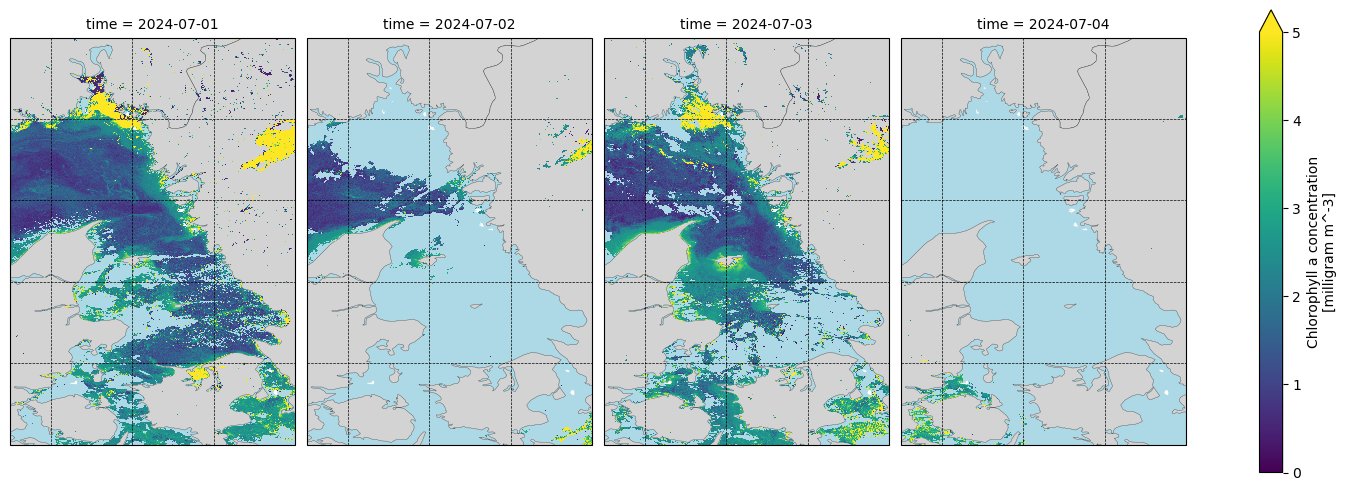

In [8]:
fig = ds.CHL.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    vmin=0, 
    vmax=5,
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-block alert-warning"> 
We now apply a forward filling technique to fill in data gaps caused by cloud cover. This takes the last valid pixel value and carries that data through in the time dimension. We limit the forward filling to 7 days to make sure that we are not looking at data outdated by more that a week. We then plot the first four days of data again to see the effect of the forward fill in comparison with the above maps which visualize the raw data. We now have a more complete dataset for mass concentration (mg/m³) of chlorophyll a in sea water (Chl-a) over our entire time series. We also calculate the mean for the dataset (ds_mean), which will be used later in the analysis.
</div>

In [9]:
## forward-fill all variables in time-series. 
## Let's also look at the first 4 days of data to visually verify that we're progressively filling in gaps
ds_fill = ds.ffill(dim='time', limit=7)
ds_fill
# remote Time dimension and average for each pixel across time series
ds_mean = ds_fill.mean(dim='time', skipna=True)

<div class="alert alert-block alert-warning"> 
Now we will visualize the first 4 days of our data. You will see that we have lots of gaps - this is due to cloud cover interfering with the OLCI sensor data acquisition. We will address this problem in the following code.
</div>

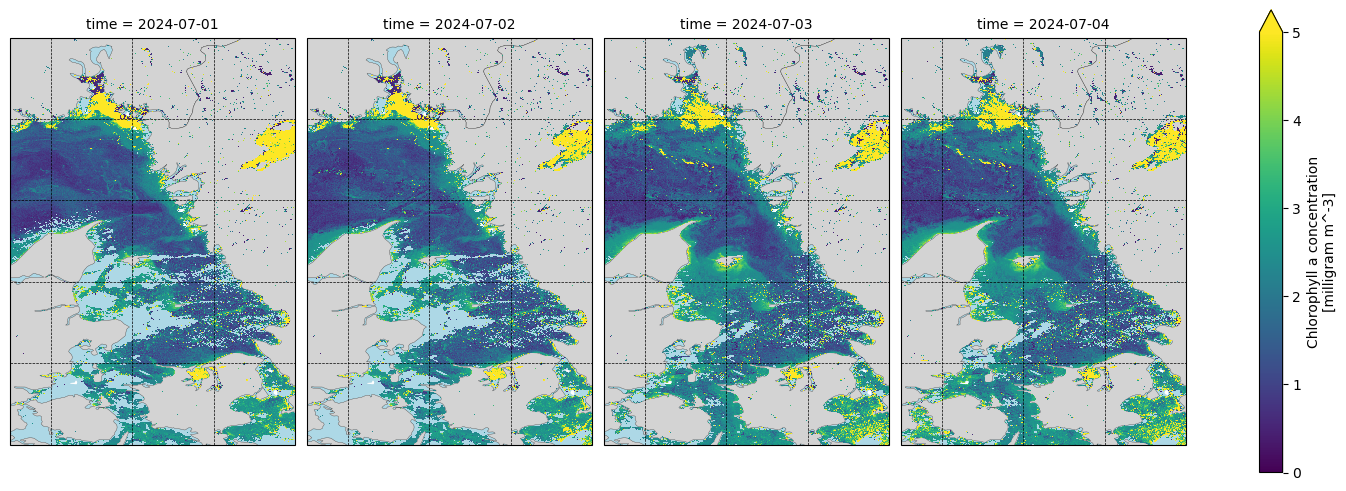

In [10]:
fig = ds_fill.CHL.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
#    col_wrap=3, 
    vmin=0, 
    vmax=5,
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-block alert-warning"> 
Now we load all coastal water body (KVF) areas, which is saved in the external data folder, for the west coast in order to clip the dataset according to the KVF areas. 
</div>

<Axes: >

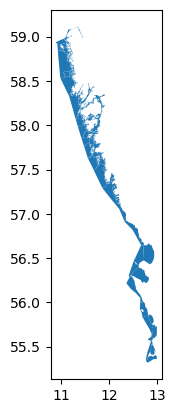

In [11]:
# read in kustvattenförekomster and clip to the study area

kvf = os.path.join('external_data', 'VM', 'vm.Kustvatten_Vattenforekomster_2016_1.shp')
kvf = gpd.read_file(kvf)
kvf = kvf.to_crs(4326)

c =  {'NW': [9.5, 60],
      'NE': [13, 60],
      'SW': [9.5, 55],
      'SE': [13, 55]}

bb = Polygon([c['NW'], c['NE'], c['SE'], c['SW']])

kvf_clipped = kvf.clip(bb)
kvf_clipped.plot()

In [12]:
# dissolve kvf by 'TYPOMRKUST'

kvf_dissolved = kvf_clipped.dissolve(by='TYPOMRKUST')
kvf_dissolved = kvf_dissolved.reset_index()
for row in kvf_dissolved.itertuples():
    print(f'Index {row.Index}: TYPOMRKUST <{row.TYPOMRKUST}>')


Index 0: TYPOMRKUST <1n>
Index 1: TYPOMRKUST <1s>
Index 2: TYPOMRKUST <2>
Index 3: TYPOMRKUST <25>
Index 4: TYPOMRKUST <3>
Index 5: TYPOMRKUST <4>
Index 6: TYPOMRKUST <5>
Index 7: TYPOMRKUST <6>
Index 8: TYPOMRKUST <7>


In [13]:
ds_mean = ds_mean.rio.write_crs(4326)
ds_mclipped=[]
for index, row in kvf_dissolved.iterrows():
    aoi = ds_mean.rio.clip([row['geometry']], all_touched=True)
    ds_mclipped.append(aoi)


In [ ]:
for ind in range(len(ds_mclipped)):
    data = ds_mclipped[ind]
    fig, ax = plt.subplots(1,1, figsize=(8, 6),subplot_kw=dict(projection=ccrs.PlateCarree()))
    data['CHL'].plot(ax=ax,vmin=0, vmax=5, zorder=2)

    kvf_dissolved.iloc[[ind]].boundary.plot(ax=ax, edgecolor="black", lw=0.2)

    try:
        area_name = kvf_dissolved.iloc[ind]['TYPOMRKUST']
    except:
        area_name = f"Area {ind}"

    ax.add_feature(land, zorder=1)    
    ax.add_feature(ocean, zorder=0)    
    bounds=kvf_dissolved.iloc[ind].geometry.bounds
    minx, miny, maxx, maxy = bounds
    pad_x = (maxx - minx) * 0.1
    pad_y = (maxy - miny) * 0.1
    ax.set_xlim(minx - pad_x, maxx + pad_x)
    ax.set_ylim(miny - pad_y, maxy + pad_y)
    ax.set_title(f"Chlorophyll a (Chl-a) in sea water (mg/m³) \n KVF:{area_name}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()##

<div class="alert alert-info" role="alert">

## <a id='section1'></a>5. EK Classification of Chlorophyll a (Chl-a) in Coastal Water Areas (KVF)
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
This step processes Chlorophyll a measurements from coastal water bodies to classify their ecological status. It utilizes thresholds from the HVMFS 2019:25 guidelines, specifically the reference values and ecological quality ratios (EK), to determine the status classes: High, Good, Moderate, Unsatisfactory, and Poor. The result is a series of maps, one per coastal water body, illustrating the EK classification. For each area, a summary table is also provided, showing the pixel count and percentage distrubution for each class within the area.
</div>

In [ ]:
# EK-table. A list containing reference values (Rv) and threshold ratios (HG, GM, MO, OD) for different water body types (Typ), as specified in HVMFS 2019:25.
ek_table = [
    {"Typ": "1n", "Rv": 1.15,   "HG": 0.76, "GM": 0.62, "MO": 0.35, "OD": 0.19},
    {"Typ": "1s", "Rv": 1.6,    "HG": 0.76, "GM": 0.57, "MO": 0.35, "OD": 0.2},
    {"Typ": "2", "Rv": 1.37,    "HG": 0.79, "GM": 0.53, "MO": 0.34, "OD": 0.23},
    {"Typ": "3",  "Rv": 0.99,   "HG": 0.79, "GM": 0.63, "MO": 0.31, "OD": 0.18},
    {"Typ": "25", "Rv": 1.8,    "HG": 0.86, "GM": 0.67, "MO": 0.44, "OD": 0.28},
    {"Typ": "4",  "Rv": 1.0,    "HG": 0.83, "GM": 0.67, "MO": 0.33, "OD": 0.17},
    {"Typ": "5",  "Rv": 0.99,   "HG": 0.83, "GM": 0.67, "MO": 0.33, "OD": 0.17},
    {"Typ": "6",  "Rv": 0.94,   "HG": 0.82, "GM": 0.59, "MO": 0.37, "OD": 0.18},
    {"Typ": "7",  "Rv": 1.3,    "HG": 0.83, "GM": 0.70, "MO": 0.40, "OD": 0.20},
]

# Dictionary mapping each water body type to its corresponding thresholds for quick access during classification
ek_dict = {row["Typ"]: row for row in ek_table}

# Dictionary assigning specific colors to each ecological status class for visualization purposes
class_colors = {
    "High": "green",
    "Good": "lightgreen",
    "Moderate": "orange",
    "Unsatisfactory": "orangered",
    "Poor": "red"
}

# Maps each status class to an integer, facilitating numerical classification
class_to_int = {k: i for i, k in enumerate(class_colors.keys())}
int_to_class = list(class_colors.keys())

# create dataArray that will hold the combined classification results for all processed water bodies
combined_array = None


"""Process Each Water Body's Data and calculates the EK ratio by dividing the reference value by the Chlorophyll a value, 
   and assigns an ecological status class based on the thresholds.The results are stored in the DataArray combined_array."""

for ind in range(len(ds_mclipped)):
    data = ds_mclipped[ind]

    try:
        typ = str(kvf_dissolved.iloc[ind]['TYPOMRKUST']).strip()
        thresholds = ek_dict[typ]
        ref = thresholds["Rv"]
    except KeyError:
        continue

    chl_a_values = data['CHL']
    ek_values = ref / chl_a_values
    valid_mask = ~np.isnan(chl_a_values)

    classification_array = np.full_like(chl_a_values, np.nan)
    mask = valid_mask.copy()
    classification_array[(ek_values > thresholds["HG"]) & mask] = class_to_int["High"]
    mask &= ~(ek_values > thresholds["HG"])
    classification_array[(ek_values > thresholds["GM"]) & mask] = class_to_int["Good"]
    mask &= ~(ek_values > thresholds["GM"])
    classification_array[(ek_values > thresholds["MO"]) & mask] = class_to_int["Moderate"]
    mask &= ~(ek_values > thresholds["MO"])
    classification_array[(ek_values > thresholds["OD"]) & mask] = class_to_int["Unsatisfactory"]
    mask &= ~(ek_values > thresholds["OD"])
    classification_array[mask] = class_to_int["Poor"]

    class_da = xr.DataArray(
        classification_array,
        coords=data['CHL'].coords,
        dims=data['CHL'].dims
    )
    
    # Combine all classifications
    if combined_array is None:
        combined_array = class_da
    else:
        combined_array = combined_array.combine_first(class_da)

    #Set Up Colormap and Normalization and ensuring that missing data is transparent
    cmap = ListedColormap([class_colors[c] for c in int_to_class])
    cmap.set_bad((0,0,0,0))
    norm = plt.Normalize(vmin=0, vmax=len(class_to_int) - 1)

    try:
        area_name = kvf_dissolved.iloc[ind]['TYPOMRKUST']
    except:
        area_name = f"Area {ind}"
        
    #Create the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 8),subplot_kw=dict(projection=ccrs.PlateCarree()))
    class_da.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
    kvf_dissolved.iloc[[ind]].plot(ax=ax, edgecolor='black', facecolor='none', lw=0.6)
    
    #Add Legend and Additional Features
    legend_patches = [mpatches.Patch(color=class_colors[label], label=label)
                  for label in int_to_class
                 ]
    ax.legend(handles=legend_patches, loc='lower left', title="EK class", frameon=True, facecolor='white')
    bounds=kvf_dissolved.iloc[ind].geometry.bounds
    minx, miny, maxx, maxy = bounds
    pad_x = (maxx - minx) * 0.4
    pad_y = (maxy - miny) * 0.4
    ax.set_xlim(minx - pad_x, maxx + pad_x)
    ax.set_ylim(miny - pad_y, maxy + pad_y)
    ax.add_feature(land, zorder=1)    
    ax.add_feature(ocean, zorder=0) 
    ax.set_title(f"EK classification (Chl-a)\n KVF:{area_name}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    

    # Flatten the classification array and exclude NaN values
    flat_array = classification_array[~np.isnan(classification_array)].astype(int).ravel()
    total_pixels = len(flat_array)
    plt.show()
    
    # Count number of pixels per class
    counts = Counter(flat_array)
    
    # Create list of rows with class name, pixel count, and percentage
    pixel_stats = []
    for class_index, count in counts.items():
        class_name = int_to_class[class_index]
        percentage = 100 * count / total_pixels
        pixel_stats.append([class_name, count, round(percentage, 1)])
    
    # Create and display the statistic table
    pixel_df = pd.DataFrame(pixel_stats, columns=["Class", "Pixel count", "(%)"])
    pixel_df.index = [''] * len(pixel_df) 
    display(pixel_df)

In [ ]:
# Define color map and normalization for Chl-a EK classification
cmap = ListedColormap([class_colors[c] for c in int_to_class])
cmap.set_bad((0, 0, 0, 0))  # Transparent for NaNs
norm = plt.Normalize(vmin=0, vmax=len(int_to_class) - 1)

# Create figure and axis with geographical projection
fig, ax = plt.subplots(1, 1, figsize=(15, 13), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot the combined classified chlorophyll a data
img = combined_array.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Add custom legend
legend_patches = [mpatches.Patch(color=class_colors[label], label=label) for label in int_to_class]
ax.legend(handles=legend_patches, loc='upper right', title="EK class", frameon=True, facecolor='white')

# Plot water body boundaries
kvf_dissolved.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Add water body labels
for idx, row in kvf_dissolved.iterrows():
    centroid = row.geometry.centroid
    label = str(row['TYPOMRKUST'])
    ax.text(
        centroid.x, centroid.y, label,
        fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.7)
    )

# Set map extent
minx, miny, maxx, maxy = kvf_dissolved.total_bounds
pad_x = (maxx - minx) * 0.05
pad_y = (maxy - miny) * 0.05
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

# Add background features and finalize plot
ax.add_feature(land, zorder=1)
ax.add_feature(ocean, zorder=0)
ax.set_title("EK classification (Chl-a)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()